## Prepare dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/pippi .

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [ ]:
import glob

# change path to display images from your local dir
img_paths = "./pippi/*.jpeg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = len(imgs)

cols = 3
rows = num_imgs_to_preview // cols
rest = num_imgs_to_preview % cols
if rest: rows +=1

image_grid(imgs[:num_imgs_to_preview], rows, cols)

Generate custom captions

In [ ]:
#import glob
#from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./pippi/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [ ]:
import json

caption_prefix = "A photo of doll PippiXL"
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix #+ caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

Free some memory

# LoRA

In [ ]:
#!cp -r /content/drive/MyDrive/pytorch_lora_weights.safetensors .

In [ ]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 19.4 MB/s eta 0:00:00


In [ ]:
# install diffusers from main
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#import torch
#from diffusers import DiffusionPipeline, AutoencoderKL

#vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
#                                    torch_dtype=torch.float16)
#pipe = DiffusionPipeline.from_pretrained(
#    "stabilityai/stable-diffusion-xl-base-1.0",
#    vae=vae,
#    torch_dtype=torch.float16,
#    variant="fp16",
#    use_safetensors=True
#)
#pipe.load_lora_weights(".",weight_name="pytorch_lora_weights.safetensors")
#_ = pipe.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
# Download diffusers SDXL DreamBooth script
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-08-19 03:30:19--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84334 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.36K  --.-KB/s    in 0.02s   

2024-08-19 03:30:19 (4.00 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84334/84334]



In [ ]:
# needed for LoRA training
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


### Start LoRA training

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [ ]:
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="pippi" \
  --output_dir="pippi_doll_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="A photo of doll PippiXL" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=800 \
  --checkpointing_steps=200 \
  --seed="0"

2024-08-19 03:31:08.443132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 03:31:08.738780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 03:31:08.821708: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 03:31:09.279663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 03:31:11.138643: W tensorflow/compiler/tf2

In [ ]:
!cp ./pippi_doll_LoRA/pytorch_lora_weights.safetensors /content/drive/MyDrive/

### Save model to hub

In [ ]:
#from huggingface_hub import interpreter_login
#interpreter_login()

Make sure the `output_dir` you specify here is the same as the one used for training

In [ ]:
#from huggingface_hub import whoami
#from pathlib import Path

#output_dir = "pippi_doll_LoRA"
#username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
#repo_id = f"{username}/{output_dir}"

Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁

To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗


In [ ]:
# push to the hub🔥
#from train_dreambooth_lora_sdxl import save_model_card
#from huggingface_hub import upload_folder, create_repo

#repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
#save_model_card(
#    repo_id = repo_id,
#    images=[],
#    base_model="stabilityai/stable-diffusion-xl-base-1.0",
#    train_text_encoder=False,
#    instance_prompt="A photo of doll PippiXL",
#    validation_prompt=None,
#    repo_folder=output_dir,
#    vae_path="madebyollin/sdxl-vae-fp16-fix",
#    use_dora=True
#)

#upload_folder(
#    repo_id=repo_id,
#    folder_path=output_dir,
#    commit_message="End of training",
#    ignore_patterns=["step_*", "epoch_*"],
#)

In [ ]:
#from IPython.display import display, Markdown

#link_to_model = f"https://huggingface.co/{repo_id}"
#display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Inference

In [ ]:
#import torch
#from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
                                    torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
#pipe.load_lora_weights("pippi_doll_LoRA",weight_name="pytorch_lora_weights.safetensors")
pipe.load_lora_weights(".",weight_name="pytorch_lora_weights.safetensors")
_ = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

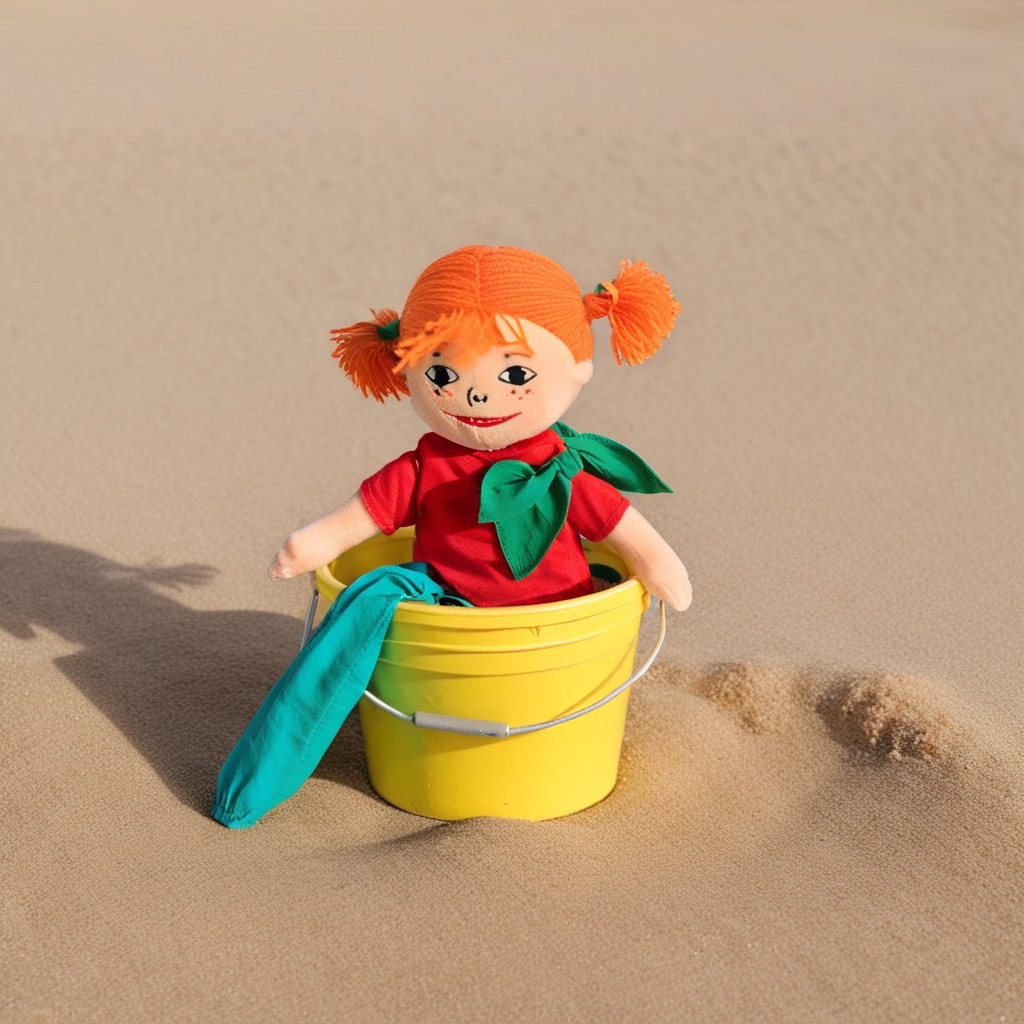

In [ ]:
prompt = "A photo of doll PippiXL in a bucket at the beach"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

  0%|          | 0/25 [00:00<?, ?it/s]

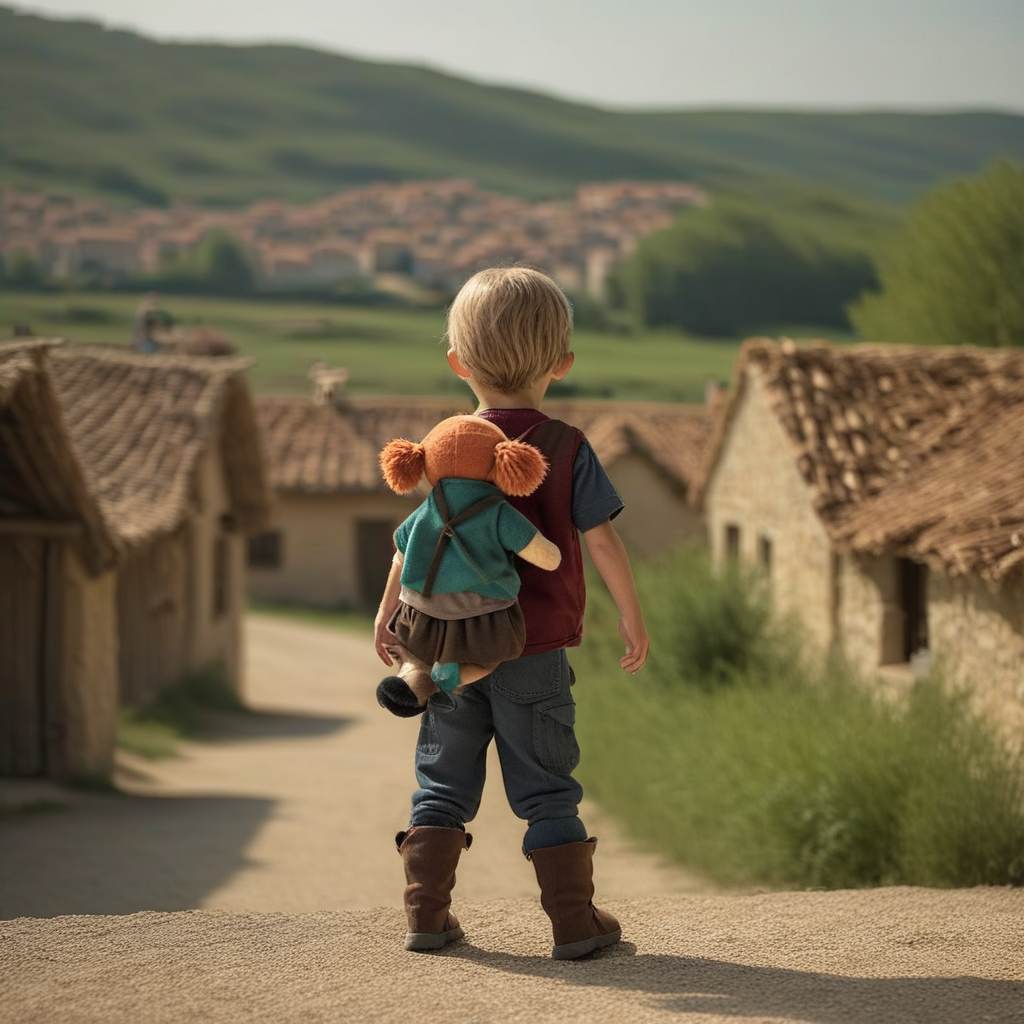

In [ ]:
prompt = "A child holding doll PippiXL, medieval village in the background, cinematic view"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

  0%|          | 0/25 [00:00<?, ?it/s]

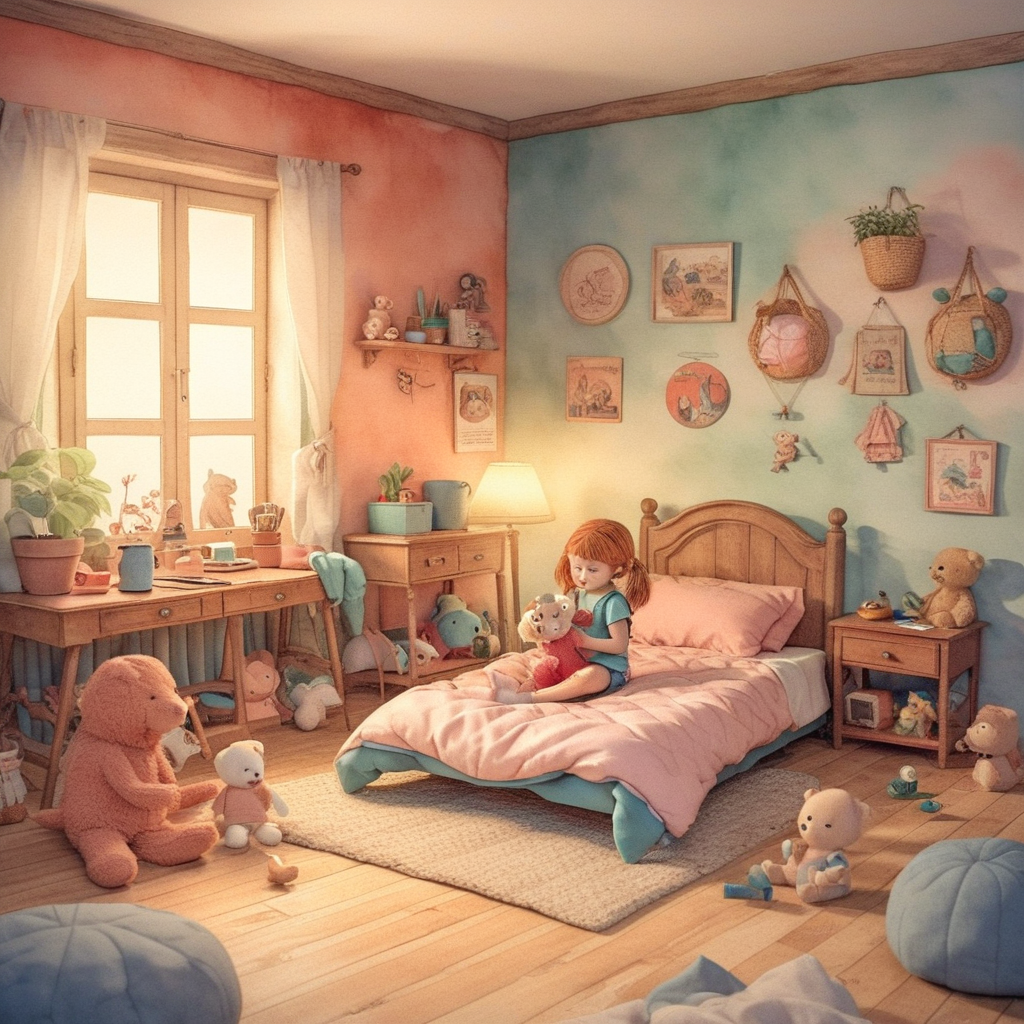

In [ ]:
prompt = "A little girl playing with doll PippiXL, a room with bed and toys in the background, fantasy, watercolor, high detail, cinematic"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image